<hr>
<br><br><br>
<div align=center>
<font size=2>
        Trabalho de Conclusão de Curso
    </font>
    <br><br><BR>
    <font size=3>
        Reconhecimento de emoções em arquivos de áudio<br>a partir da extração de descritores espectrais
    </font>
    <br><br><BR>
    <font size=2>
        ICMC-USP
    </font>    
</div>
<br><br><br>
<hr>

<br><br>
<a id=menu></a>

[Biblotecas](#libs) <br>
[Dados](#data) <br>
[Pré-processamento](#prep) <br>
[Processamento](#proc) <br>
[Avaliação](#aval) <br>

<br>

<a id='libs'></a>
###<h3>Bibliotecas</h3>
<br>
<blockquote>
    <dl>
        <dl>- Matplotlib: criação de gráficos e visuadlzação de dados.</dl>
        <dl>- Numpy: processamento de vetores e matrizes multimensionais.</dl>
        <dl>- Pandas: manipulação e análise de dados tabulares e séries temporais</dl>
        <dl>- Seaborn: criação de gráficos e visualização de dados.</dl>
        <dl>- Sklearn: algoritmos de aprendizado de máquina.</dl>
    </dl>
</blockquote>


In [ ]:
import numpy as np 
import pandas as pd 

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, log_loss, roc_auc_score)

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt 
import seaborn as sns
import time



<a id='proc'></a>
### <h3>Dados</h3>

<font size=1>[menu](#menu)</font>

In [ ]:
folder_path = '../data/'
file_name = 'voice_features_raw_40.csv'
df = pd.read_csv(folder_path + file_name)
print(df.shape)

(1440, 290)


In [ ]:
### Exclude neutral emotion file as recommended for ravdess researches
df = df[df.emotion!='neutral']
print(df.shape)
df.head(2)

(1344, 290)


,MEL_0,MEL_1,MEL_2,MEL_3,MEL_4,MEL_5,MEL_6,MEL_7,MEL_8,MEL_9,MEL_10,MEL_11,MEL_12,MEL_13,MEL_14,MEL_15,MEL_16,MEL_17,MEL_18,MEL_19,MEL_20,MEL_21,MEL_22,MEL_23,MEL_24,MEL_25,MEL_26,MEL_27,MEL_28,MEL_29,MEL_30,MEL_31,MEL_32,MEL_33,MEL_34,MEL_35,MEL_36,MEL_37,MEL_38,MEL_39,...,PNCC_2,PNCC_3,PNCC_4,PNCC_5,PNCC_6,PNCC_7,PNCC_8,PNCC_9,PNCC_10,PNCC_11,PNCC_12,PNCC_13,PNCC_14,PNCC_15,PNCC_16,PNCC_17,PNCC_18,PNCC_19,PNCC_20,PNCC_21,PNCC_22,PNCC_23,PNCC_24,PNCC_25,PNCC_26,PNCC_27,PNCC_28,PNCC_29,PNCC_30,PNCC_31,PNCC_32,PNCC_33,PNCC_34,PNCC_35,PNCC_36,PNCC_37,PNCC_38,PNCC_39,emotion,actor
1,0.000013,0.000555,0.009175,0.020292,0.018322,0.006961,0.013214,0.015581,0.016653,0.013299,0.004880,0.005009,0.009620,0.019270,0.014089,0.002810,0.002958,0.008433,0.005448,0.000935,0.001446,0.004113,0.002633,0.000371,0.000264,0.000293,0.000107,0.000083,0.000176,0.000178,0.000349,0.000179,0.000137,0.000242,0.000957,0.001207,0.000271,0.000193,0.000659,0.000289,...,1.112999e-15,-1.565414e-16,-4.342591e-17,-7.081141e-17,1.091719e-16,-1.194646e-17,8.420926e-17,1.039678e-17,-4.801715e-17,1.678634e-17,8.211024e-19,1.658396e-17,-1.601728e-17,4.255855e-18,1.233967e-17,2.775558e-17,-7.355228e-18,-3.885781e-18,6.846375e-18,1.156482e-17,-1.639892e-17,-5.701458e-18,-2.645453e-18,-1.934217e-18,6.924438e-19,5.611830e-18,-4.475587e-18,-1.725616e-17,-1.747445e-17,-3.006854e-19,-1.001514e-17,1.554023e-17,-2.740863e-17,-1.116005e-18,1.503427e-19,-3.920475e-18,-4.377286e-17,1.356265e-17,calm,Actor_01
3,0.000019,0.002271,0.016217,0.018024,0.022248,0.010594,0.008520,0.006765,0.013506,0.017910,0.005543,0.003556,0.006492,0.015117,0.026937,0.011562,0.004729,0.001525,0.004829,0.008202,0.002394,0.001630,0.003089,0.003037,0.000795,0.000218,0.000097,0.000173,0.000314,0.000339,0.000545,0.000550,0.000329,0.000554,0.001086,0.000789,0.000368,0.000401,0.000178,0.000251,...,1.409798e-15,2.046511e-16,-6.226501e-17,8.234154e-18,5.588123e-17,5.153285e-17,5.819419e-17,5.241178e-17,1.767105e-17,9.483155e-19,3.249715e-17,-1.262879e-17,4.772803e-17,-3.727343e-17,-3.402371e-17,-6.383782e-18,7.864080e-19,2.885423e-18,-2.347659e-18,-1.748601e-17,-8.766136e-18,1.541591e-17,2.562765e-17,1.484923e-17,-1.440977e-17,-1.827242e-18,9.043692e-18,1.299886e-17,2.279427e-17,-3.885781e-18,4.695318e-18,-8.615793e-18,4.625929e-19,3.660267e-18,9.830100e-19,-2.700386e-18,-5.863365e-18,9.110189e-18,calm,Actor_01


In [ ]:
features_name = ['MEL','CHROMA','MFCC','GFCC','PNCC']
features_interval = [(0,128),(128,168),(168,208),(208,248),(248,288)]

In [ ]:
def split_data_by_feature(data: pd.DataFrame, features_interval: list) -> dict:
    data_dict = {}
    for idx, interval in enumerate(features_interval):
      data_dict[features_name[idx]] = data.iloc[:,interval[0]:interval[1]]
    
    return data_dict


In [ ]:
features_dict = split_data_by_feature(df, features_interval)
features_dict.keys()

dict_keys(['MEL', 'CHROMA', 'MFCC', 'GFCC', 'PNCC'])


<a id='proc'></a>
### <h3>Processamento</h3>

<font size=1>[menu](#menu)</font>

In [ ]:

target = df.emotion.values

ft = 'MFCC'
X = features_dict[ft]


le = LabelEncoder()
le.fit(target)
y = le.transform(target)

print(X.shape)
print(y.shape)

(1344, 40)
(1344,)


In [ ]:
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    stratify=y, random_state=42)


In [ ]:
print(X_train.shape)
print(X_test.shape)

(1075, 40)
(269, 40)


In [ ]:
### Normalize data

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


#### Base Model

In [ ]:
clf_bas = LogisticRegression(max_iter=3000, random_state=42)
clf_bas.fit(X_train, y_train)
 

LogisticRegression(max_iter=3000, random_state=42)

In [ ]:
# print prediction results
y_pred = clf_bas.predict(X_test)
print(f'\t\t\tSVM / {ft} REPORT\n')
print(classification_report(y_test, y_pred))

			SVM / MFCC REPORT

              precision    recall  f1-score   support

           0       0.68      0.61      0.64        38
           1       0.51      0.55      0.53        38
           2       0.36      0.34      0.35        38
           3       0.53      0.54      0.53        39
           4       0.49      0.46      0.47        39
           5       0.38      0.39      0.38        38
           6       0.37      0.38      0.37        39

    accuracy                           0.47       269
   macro avg       0.47      0.47      0.47       269
weighted avg       0.47      0.47      0.47       269



In [ ]:
predictions_prob = clf_bas.predict_proba(X_test)

auc = roc_auc_score(y_test, predictions_prob, multi_class='ovr')
loss = log_loss(y_test, predictions_prob)
print(f'AUC: {round(auc,2)} | Loss: {round(loss,2)}')

AUC: 0.85 | Loss: 1.3


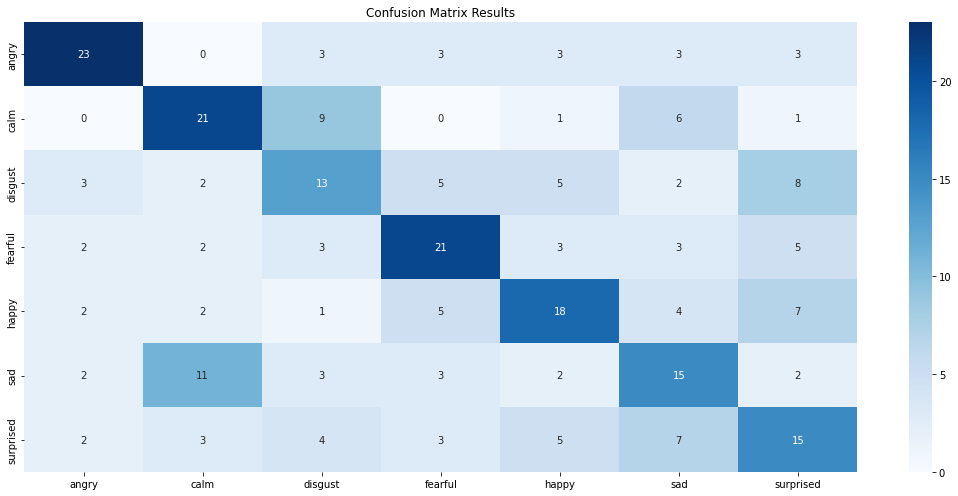

In [ ]:
y_test_r = le.inverse_transform(y_test)
y_pred_r = le.inverse_transform(y_pred)

cm = confusion_matrix(y_test_r, y_pred_r, labels=le.classes_)
plt.figure(figsize = (15,7))
plt.title('Confusion Matrix Results')

sns.heatmap(cm, cmap="Blues", annot=True,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.tight_layout()


#### Hyper-params tuning

In [ ]:
 
# defining parameter range
param_grid = {'C': np.arange(.001,100,1),
              'solver':['newton-cg', 'sag', 'saga' ,'lbfgs'],
              'max_iter':[1000],
              'multi_class':['ovr'],
              'penalty':['l1','l2']}
 
clf = GridSearchCV(LogisticRegression(), param_grid, cv=10, refit = True, verbose = 0)
 
# fitting the model for grid search
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3000 fits failed out of a total of 8000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1000 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: 

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.0000e-03, 1.0010e+00, 2.0010e+00, 3.0010e+00, 4.0010e+00,
       5.0010e+00, 6.0010e+00, 7.0010e+00, 8.0010e+00, 9.0010e+00,
       1.0001e+01, 1.1001e+01, 1.2001e+01, 1.3001e+01, 1.4001e+01,
       1.5001e+01, 1.6001e+01, 1.7001e+01, 1.8001e+01, 1.9001e+01,
       2.0001e+01, 2.1001e+01, 2.2001e+01, 2.3001e+01, 2.4001e+01,
       2....
       7.5001e+01, 7.6001e+01, 7.7001e+01, 7.8001e+01, 7.9001e+01,
       8.0001e+01, 8.1001e+01, 8.2001e+01, 8.3001e+01, 8.4001e+01,
       8.5001e+01, 8.6001e+01, 8.7001e+01, 8.8001e+01, 8.9001e+01,
       9.0001e+01, 9.1001e+01, 9.2001e+01, 9.3001e+01, 9.4001e+01,
       9.5001e+01, 9.6001e+01, 9.7001e+01, 9.8001e+01, 9.9001e+01]),
                         'max_iter': [1000], 'multi_class': ['ovr'],
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']})

In [ ]:
# print best parameter after tuning
best_params = clf.best_params_
print(best_params)


{'C': 7, 'max_iter': 1000, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'newton-cg'}


In [ ]:
# print prediction results
predictions = clf.predict(X_test)
print(f'\t\t\tSVM / {ft} REPORT\n')
print(classification_report(y_test, predictions))

			SVM / GFCC REPORT

              precision    recall  f1-score   support

           0       0.12      0.16      0.14        38
           1       0.08      0.11      0.09        38
           2       0.15      0.16      0.15        38
           3       0.22      0.21      0.21        39
           4       0.11      0.08      0.09        39
           5       0.07      0.08      0.07        38
           6       0.17      0.10      0.13        39

    accuracy                           0.13       269
   macro avg       0.13      0.13      0.13       269
weighted avg       0.13      0.13      0.13       269



In [ ]:
from sklearn.metrics import roc_auc_score
predictions_prob = clf.predict_proba(X_test)

auc = roc_auc_score(y_test, predictions_prob, multi_class='ovr')
loss = log_loss(y_test, predictions_prob)
print(f'AUC: {round(auc,2)} | Loss: {round(loss,2)}')

AUC: 0.48 | Loss: 2.1


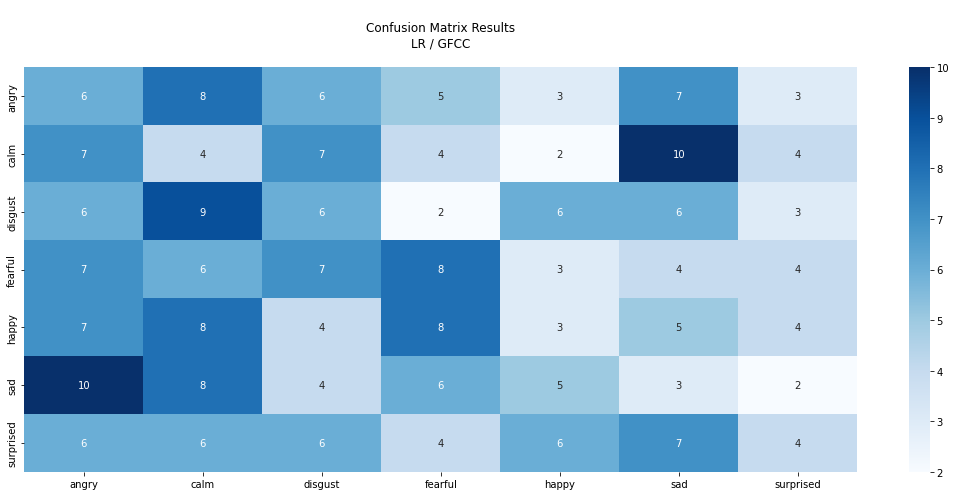

In [ ]:
y_pred = clf.predict(X_test)
y_pred_r = le.inverse_transform(y_pred)

cm = confusion_matrix(y_test_r, y_pred_r, labels=le.classes_)
plt.figure(figsize = (15,7))
plt.title(f'\nConfusion Matrix Results\nLR / {ft}\n', size=12)

sns.heatmap(cm, cmap="Blues", annot=True,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.savefig(f'/content/drive/MyDrive/MBA/TCC/lr-{ft.lower()}-cm.png', dpi=300)
plt.tight_layout()


#### Cross Validation 

In [ ]:
# best_params['max_iter'] = 3000

In [ ]:

folds = 10
strat_kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

results_cv = {'auc':[],'loss':[],'acc':[],'model':[]}

for idx, (train_idx, test_idx) in enumerate(strat_kf.split(X_train, y_train)):
    print("=" * 20 + f"\n\nTraining fold {idx+1}")
    start = time.time()

    x_train, X_val = X_train[train_idx], X_train[test_idx]
    Y_train, y_val = y_train[train_idx], y_train[test_idx]
    eval_set = [(X_val, y_val)]

    clf_cv = LogisticRegression(**best_params, random_state=42)
    clf_cv.fit(x_train, Y_train)


    acc = accuracy_score(y_val, clf.predict(X_val))
    loss = log_loss(y_val, clf.predict_proba(X_val))
    auc = roc_auc_score(y_val, clf.predict_proba(X_val), multi_class='ovr')


    results_cv['model'].append(clf_cv)
    results_cv['acc'].append(acc)
    results_cv['loss'].append(loss)
    results_cv['auc'].append(auc)

    print(f'Accuracy: {round(acc,2)} | Loss: {round(loss,2)} | AUC: {round(auc,2)}')
    runtime = time.time() - start
    print(f"\nFinished in {runtime:.2f} seconds.\n")


Training fold 1
Accuracy: 0.27 | Loss: 1.84 | AUC: 0.66

Finished in 0.07 seconds.


Training fold 2
Accuracy: 0.25 | Loss: 1.85 | AUC: 0.64

Finished in 0.19 seconds.


Training fold 3
Accuracy: 0.32 | Loss: 1.75 | AUC: 0.71

Finished in 0.07 seconds.


Training fold 4
Accuracy: 0.21 | Loss: 1.87 | AUC: 0.63

Finished in 0.08 seconds.


Training fold 5
Accuracy: 0.3 | Loss: 1.8 | AUC: 0.68

Finished in 0.07 seconds.


Training fold 6
Accuracy: 0.26 | Loss: 1.83 | AUC: 0.66

Finished in 0.08 seconds.


Training fold 7
Accuracy: 0.24 | Loss: 1.84 | AUC: 0.65

Finished in 0.07 seconds.


Training fold 8
Accuracy: 0.24 | Loss: 1.87 | AUC: 0.63

Finished in 0.07 seconds.


Training fold 9
Accuracy: 0.24 | Loss: 1.82 | AUC: 0.67

Finished in 0.06 seconds.


Training fold 10
Accuracy: 0.26 | Loss: 1.81 | AUC: 0.67

Finished in 0.08 seconds.



In [ ]:
svm_cv = pd.DataFrame(results_cv).sort_values(by=['auc','loss','acc'],ascending=[False,True,False])
round(svm_cv,2)

,auc,loss,acc,model
2,0.71,1.75,0.32,"LogisticRegression(C=7, max_iter=1000, random_..."
4,0.68,1.80,0.30,"LogisticRegression(C=7, max_iter=1000, random_..."
8,0.67,1.82,0.24,"LogisticRegression(C=7, max_iter=1000, random_..."
9,0.67,1.81,0.26,"LogisticRegression(C=7, max_iter=1000, random_..."
0,0.66,1.84,0.27,"LogisticRegression(C=7, max_iter=1000, random_..."
5,0.66,1.83,0.26,"LogisticRegression(C=7, max_iter=1000, random_..."
6,0.65,1.84,0.24,"LogisticRegression(C=7, max_iter=1000, random_..."
1,0.64,1.85,0.25,"LogisticRegression(C=7, max_iter=1000, random_..."
7,0.63,1.87,0.24,"LogisticRegression(C=7, max_iter=1000, random_..."
3,0.63,1.87,0.21,"LogisticRegression(C=7, max_iter=1000, random_..."


In [ ]:
clf_best = svm_cv.loc[4,'model']

In [ ]:
# print prediction results
predictions = clf_best.predict(X_test)
print(f'\t\tLR / {ft} REPORT\n')
print(classification_report(y_test, predictions))

		LR / GFCC REPORT

              precision    recall  f1-score   support

           0       0.12      0.18      0.15        38
           1       0.09      0.11      0.10        38
           2       0.26      0.24      0.25        38
           3       0.17      0.15      0.16        39
           4       0.16      0.13      0.14        39
           5       0.13      0.13      0.13        38
           6       0.23      0.18      0.20        39

    accuracy                           0.16       269
   macro avg       0.17      0.16      0.16       269
weighted avg       0.17      0.16      0.16       269



In [ ]:
predictions_prob = clf_best.predict_proba(X_test)
auc = roc_auc_score(y_test, predictions_prob, multi_class='ovr')
loss = log_loss(y_test, predictions_prob)
print(f'AUC: {round(auc,2)} | Loss: {round(loss,2)}')

AUC: 0.49 | Loss: 2.11


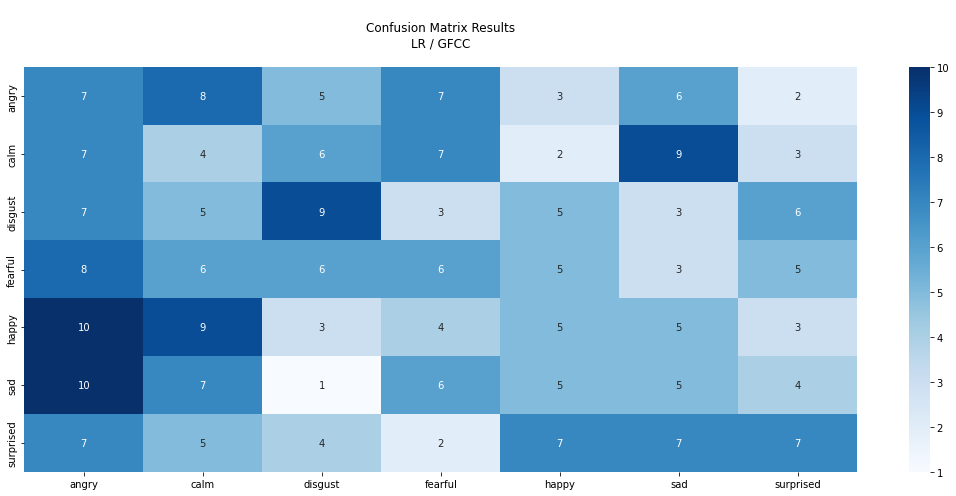

In [ ]:
y_pred = clf_best.predict(X_test)
y_pred_r = le.inverse_transform(y_pred)

cm = confusion_matrix(y_test_r, y_pred_r, labels=le.classes_)
plt.figure(figsize = (15,7))
plt.title(f'\nConfusion Matrix Results\nLR / {ft}\n', size=12)

sns.heatmap(cm, cmap="Blues", annot=True,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.savefig(f'/content/drive/MyDrive/MBA/TCC/lr-{ft.lower()}-cm.png', dpi=300)
plt.tight_layout()


#### OVA Approach

In [ ]:
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score


In [ ]:
from sklearn import preprocessing
lb = LabelBinarizer()
lb.fit(list(set(y_test)))


In [ ]:
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)
n_classes = y_train.shape[1]


In [ ]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(
    SVC(**best_params, random_state=42)
)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)



In [ ]:
y_pred = classifier.predict(X_test)
y_pred_r = le.inverse_transform(lb.inverse_transform(y_pred))

cm = confusion_matrix(y_test_r, y_pred_r, labels=le.classes_)
plt.figure(figsize = (15,7))
plt.title('Confusion Matrix Results')

sns.heatmap(cm, cmap="Blues", annot=True,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.tight_layout()

In [ ]:
 # print prediction results
# y_pred = classifier.predict(X_test)
y_pred = classifier.predict_proba(X_test)
y_pred = [y.argmax() for y in y_pred]
y_pred = label_binarize(y_pred, classes=list(set(y_pred)))
print(classification_report(y_test, y_pred, labels=np.unique(y_test),zero_division=0))

In [ ]:
predictions_prob = classifier.predict_proba(X_test)

auc_score = roc_auc_score(y_test, predictions_prob, multi_class='ovr')
loss = log_loss(y_test, predictions_prob)
print(f'AUC: {round(auc,2)} | Loss: {round(loss,2)}')

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

In [ ]:

plt.figure(figsize=(15,8))
# Plot all ROC curves
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue","mediumseagreen",
                "orchid","tomato","goldenrod"])
line_width = 2
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=line_width,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=line_width)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

<hr>
<br><br>
<div align=right>
    <font size=2>
        Julio Valim &emsp;
    </font>
    <br>
    <font size=1>
        <a href='https://www.linkedin.com/in/juliovalim'>contato /in</a>&emsp;&emsp;
    </font>
</div>